# Models to use
codewithdark/vit-chest-xray
VIT - Transformer based
https://arxiv.org/pdf/2010.11929
While the Transformer architecture has become the de-facto standard for natural
language processing tasks, its applications to computer vision remain limited. In
vision, attention is either applied in conjunction with convolutional networks, or
used to replace certain components of convolutional networks while keeping their
overall structure in place. We show that this reliance on CNNs is not necessary
and a pure transformer applied directly to sequences of image patches can perform
very well on image classification tasks. When pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks
(ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent
results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.

DataMinds/cnn_brain_tumor_classification 
CNN
Trained on brain tumor data that used MRIs. 

dyaminda/alexnet-pneumonia
Alexnet - ImageNet Subclass?
https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
It contains eight learned layers —
five convolutional and three fully-connected.

ryefoxlime/PneumoniaDetection
Resnet
Finetuned Paper - https://pubmed.ncbi.nlm.nih.gov/32501424/
Already trained on Covid-19, pneumonia and normal classes


## Helpful Articles about CNNs and ImageNets
https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96#:~:text=AlexNet%20was%20born%20out%20of,with%20an%20accuracy%20of%2073.8%25.



In [1]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='Bone Break Classification')

c:\Users\jonpg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 989
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 140
    })
})

In [3]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [4]:
labels

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

In [5]:
id2label

{'0': 'Avulsion fracture',
 '1': 'Comminuted fracture',
 '2': 'Fracture Dislocation',
 '3': 'Greenstick fracture',
 '4': 'Hairline Fracture',
 '5': 'Impacted fracture',
 '6': 'Longitudinal fracture',
 '7': 'Oblique fracture',
 '8': 'Pathological fracture',
 '9': 'Spiral Fracture'}

In [6]:
from transformers import AutoImageProcessor

checkpoint = "codewithdark/vit-chest-xray"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

c:\Users\jonpg\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jonpg\.cache\huggingface\hub\models--codewithdark--vit-chest-xray. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [8]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [9]:
images = dataset.with_transform(transforms)

In [10]:
images

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 989
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 140
    })
})

In [11]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Evaluate

In [12]:
import evaluate

accuracy = evaluate.load("accuracy")

In [13]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at codewithdark/vit-chest-xray and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir="results/vit_bone_fractures",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=images["train"],
    eval_dataset=images["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)



c:\Users\jonpg\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
trainer.train()

  1%|          | 10/989 [00:09<15:23,  1.06it/s]

{'loss': 2.1464, 'grad_norm': 41.56371307373047, 'learning_rate': 5.050505050505051e-06, 'epoch': 0.01}


  2%|▏         | 20/989 [00:19<15:15,  1.06it/s]

{'loss': 2.2141, 'grad_norm': 36.2880973815918, 'learning_rate': 1.0101010101010101e-05, 'epoch': 0.02}


  3%|▎         | 30/989 [00:29<15:56,  1.00it/s]

{'loss': 2.4283, 'grad_norm': 28.540040969848633, 'learning_rate': 1.5151515151515153e-05, 'epoch': 0.03}


  4%|▍         | 40/989 [00:39<15:51,  1.00s/it]

{'loss': 2.3746, 'grad_norm': 70.07654571533203, 'learning_rate': 2.0202020202020203e-05, 'epoch': 0.04}


  5%|▌         | 50/989 [00:50<16:39,  1.06s/it]

{'loss': 2.3593, 'grad_norm': 28.32916259765625, 'learning_rate': 2.5252525252525256e-05, 'epoch': 0.05}


  6%|▌         | 60/989 [01:01<17:49,  1.15s/it]

{'loss': 2.4631, 'grad_norm': 33.17760467529297, 'learning_rate': 3.0303030303030306e-05, 'epoch': 0.06}


  7%|▋         | 70/989 [01:13<17:35,  1.15s/it]

{'loss': 2.2029, 'grad_norm': 27.529138565063477, 'learning_rate': 3.535353535353535e-05, 'epoch': 0.07}


  8%|▊         | 80/989 [01:24<16:01,  1.06s/it]

{'loss': 2.4815, 'grad_norm': 26.40743064880371, 'learning_rate': 4.0404040404040405e-05, 'epoch': 0.08}


  9%|▉         | 90/989 [01:34<15:50,  1.06s/it]

{'loss': 2.5489, 'grad_norm': 33.22452163696289, 'learning_rate': 4.545454545454546e-05, 'epoch': 0.09}


 10%|█         | 100/989 [01:52<31:38,  2.14s/it]

{'loss': 2.2767, 'grad_norm': 30.823312759399414, 'learning_rate': 4.9943820224719104e-05, 'epoch': 0.1}


 11%|█         | 110/989 [02:15<33:18,  2.27s/it]

{'loss': 2.2971, 'grad_norm': 25.9482479095459, 'learning_rate': 4.938202247191012e-05, 'epoch': 0.11}


 12%|█▏        | 120/989 [02:36<30:08,  2.08s/it]

{'loss': 2.2432, 'grad_norm': 30.621286392211914, 'learning_rate': 4.8820224719101126e-05, 'epoch': 0.12}


 13%|█▎        | 130/989 [02:58<31:11,  2.18s/it]

{'loss': 2.0627, 'grad_norm': 31.953800201416016, 'learning_rate': 4.825842696629213e-05, 'epoch': 0.13}


 14%|█▍        | 140/989 [03:22<35:07,  2.48s/it]

{'loss': 2.3892, 'grad_norm': 25.090435028076172, 'learning_rate': 4.769662921348315e-05, 'epoch': 0.14}


 15%|█▌        | 150/989 [03:51<40:08,  2.87s/it]

{'loss': 2.3909, 'grad_norm': 26.136268615722656, 'learning_rate': 4.713483146067416e-05, 'epoch': 0.15}


 16%|█▌        | 160/989 [04:15<30:33,  2.21s/it]

{'loss': 2.5425, 'grad_norm': 26.856159210205078, 'learning_rate': 4.657303370786517e-05, 'epoch': 0.16}


 17%|█▋        | 170/989 [04:35<26:53,  1.97s/it]

{'loss': 2.168, 'grad_norm': 32.27904510498047, 'learning_rate': 4.6011235955056184e-05, 'epoch': 0.17}


 18%|█▊        | 180/989 [04:56<30:21,  2.25s/it]

{'loss': 2.4385, 'grad_norm': 21.86817741394043, 'learning_rate': 4.544943820224719e-05, 'epoch': 0.18}


 19%|█▉        | 190/989 [05:18<28:37,  2.15s/it]

{'loss': 2.3108, 'grad_norm': 23.053539276123047, 'learning_rate': 4.4887640449438206e-05, 'epoch': 0.19}


 20%|██        | 200/989 [05:39<27:36,  2.10s/it]

{'loss': 2.2254, 'grad_norm': 27.796653747558594, 'learning_rate': 4.432584269662921e-05, 'epoch': 0.2}


 21%|██        | 210/989 [06:02<29:58,  2.31s/it]

{'loss': 2.6272, 'grad_norm': 21.206478118896484, 'learning_rate': 4.376404494382023e-05, 'epoch': 0.21}


 22%|██▏       | 220/989 [06:25<28:46,  2.25s/it]

{'loss': 2.4711, 'grad_norm': 25.663719177246094, 'learning_rate': 4.3202247191011235e-05, 'epoch': 0.22}


 23%|██▎       | 230/989 [06:46<27:29,  2.17s/it]

{'loss': 2.303, 'grad_norm': 24.483110427856445, 'learning_rate': 4.264044943820225e-05, 'epoch': 0.23}


 24%|██▍       | 240/989 [07:08<29:01,  2.32s/it]

{'loss': 2.6868, 'grad_norm': 27.016141891479492, 'learning_rate': 4.2078651685393264e-05, 'epoch': 0.24}


 25%|██▌       | 250/989 [07:29<25:35,  2.08s/it]

{'loss': 2.0654, 'grad_norm': 18.476381301879883, 'learning_rate': 4.151685393258427e-05, 'epoch': 0.25}


 26%|██▋       | 260/989 [07:50<25:03,  2.06s/it]

{'loss': 2.5013, 'grad_norm': 22.267841339111328, 'learning_rate': 4.095505617977528e-05, 'epoch': 0.26}


 27%|██▋       | 270/989 [08:10<24:06,  2.01s/it]

{'loss': 2.0696, 'grad_norm': 19.750429153442383, 'learning_rate': 4.039325842696629e-05, 'epoch': 0.27}


 28%|██▊       | 280/989 [08:30<23:47,  2.01s/it]

{'loss': 2.0966, 'grad_norm': 23.94439697265625, 'learning_rate': 3.983146067415731e-05, 'epoch': 0.28}


 29%|██▉       | 290/989 [08:50<23:10,  1.99s/it]

{'loss': 2.7467, 'grad_norm': 33.2324333190918, 'learning_rate': 3.9269662921348315e-05, 'epoch': 0.29}


 30%|███       | 300/989 [09:10<24:27,  2.13s/it]

{'loss': 2.3468, 'grad_norm': 28.070114135742188, 'learning_rate': 3.870786516853932e-05, 'epoch': 0.3}


 31%|███▏      | 310/989 [09:31<21:50,  1.93s/it]

{'loss': 2.4049, 'grad_norm': 25.947900772094727, 'learning_rate': 3.8146067415730344e-05, 'epoch': 0.31}


 32%|███▏      | 320/989 [09:50<21:15,  1.91s/it]

{'loss': 2.2884, 'grad_norm': 28.29290771484375, 'learning_rate': 3.758426966292135e-05, 'epoch': 0.32}


 33%|███▎      | 330/989 [10:11<23:09,  2.11s/it]

{'loss': 2.0832, 'grad_norm': 26.739891052246094, 'learning_rate': 3.702247191011236e-05, 'epoch': 0.33}


 34%|███▍      | 340/989 [10:32<22:30,  2.08s/it]

{'loss': 2.4707, 'grad_norm': 24.819555282592773, 'learning_rate': 3.646067415730337e-05, 'epoch': 0.34}


 35%|███▌      | 350/989 [10:51<21:04,  1.98s/it]

{'loss': 1.8078, 'grad_norm': 32.01939392089844, 'learning_rate': 3.589887640449439e-05, 'epoch': 0.35}


 36%|███▋      | 360/989 [11:12<21:36,  2.06s/it]

{'loss': 2.694, 'grad_norm': 24.787967681884766, 'learning_rate': 3.5337078651685395e-05, 'epoch': 0.36}


 37%|███▋      | 370/989 [11:32<20:18,  1.97s/it]

{'loss': 2.1221, 'grad_norm': 20.789501190185547, 'learning_rate': 3.47752808988764e-05, 'epoch': 0.37}


 38%|███▊      | 380/989 [11:52<20:35,  2.03s/it]

{'loss': 2.1878, 'grad_norm': 24.50058937072754, 'learning_rate': 3.421348314606742e-05, 'epoch': 0.38}


 39%|███▉      | 390/989 [12:12<20:00,  2.00s/it]

{'loss': 2.5454, 'grad_norm': 20.09003448486328, 'learning_rate': 3.365168539325843e-05, 'epoch': 0.39}


 40%|████      | 400/989 [12:33<21:45,  2.22s/it]

{'loss': 2.2682, 'grad_norm': 19.172954559326172, 'learning_rate': 3.308988764044944e-05, 'epoch': 0.4}


 41%|████▏     | 410/989 [12:57<24:23,  2.53s/it]

{'loss': 2.3034, 'grad_norm': 19.79077911376953, 'learning_rate': 3.252808988764045e-05, 'epoch': 0.41}


 42%|████▏     | 420/989 [13:20<22:14,  2.34s/it]

{'loss': 2.2874, 'grad_norm': 19.5357666015625, 'learning_rate': 3.196629213483146e-05, 'epoch': 0.42}


 43%|████▎     | 430/989 [13:43<20:32,  2.20s/it]

{'loss': 2.495, 'grad_norm': 22.12723731994629, 'learning_rate': 3.1404494382022475e-05, 'epoch': 0.43}


 44%|████▍     | 440/989 [14:05<20:22,  2.23s/it]

{'loss': 2.3077, 'grad_norm': 21.97751808166504, 'learning_rate': 3.084269662921348e-05, 'epoch': 0.44}


 46%|████▌     | 450/989 [14:25<17:19,  1.93s/it]

{'loss': 2.157, 'grad_norm': 19.40669822692871, 'learning_rate': 3.0280898876404497e-05, 'epoch': 0.46}


 47%|████▋     | 460/989 [14:45<17:49,  2.02s/it]

{'loss': 2.0393, 'grad_norm': 20.10376739501953, 'learning_rate': 2.9719101123595505e-05, 'epoch': 0.47}


 48%|████▊     | 470/989 [15:06<17:48,  2.06s/it]

{'loss': 2.1329, 'grad_norm': 22.33499526977539, 'learning_rate': 2.9157303370786522e-05, 'epoch': 0.48}


 49%|████▊     | 480/989 [15:27<16:49,  1.98s/it]

{'loss': 2.4925, 'grad_norm': 23.854928970336914, 'learning_rate': 2.859550561797753e-05, 'epoch': 0.49}


 50%|████▉     | 490/989 [15:48<18:03,  2.17s/it]

{'loss': 2.1663, 'grad_norm': 21.589847564697266, 'learning_rate': 2.803370786516854e-05, 'epoch': 0.5}


 51%|█████     | 500/989 [16:07<16:23,  2.01s/it]

{'loss': 1.8859, 'grad_norm': 25.093555450439453, 'learning_rate': 2.7471910112359552e-05, 'epoch': 0.51}


 52%|█████▏    | 510/989 [16:27<16:09,  2.02s/it]

{'loss': 2.8109, 'grad_norm': 24.899789810180664, 'learning_rate': 2.6910112359550566e-05, 'epoch': 0.52}


 53%|█████▎    | 520/989 [16:47<15:28,  1.98s/it]

{'loss': 2.4751, 'grad_norm': 27.149831771850586, 'learning_rate': 2.6348314606741577e-05, 'epoch': 0.53}


 54%|█████▎    | 530/989 [17:08<17:32,  2.29s/it]

{'loss': 2.2201, 'grad_norm': 28.493852615356445, 'learning_rate': 2.5786516853932585e-05, 'epoch': 0.54}


 55%|█████▍    | 540/989 [17:32<17:04,  2.28s/it]

{'loss': 2.376, 'grad_norm': 24.95263671875, 'learning_rate': 2.5224719101123595e-05, 'epoch': 0.55}


 56%|█████▌    | 550/989 [17:55<16:37,  2.27s/it]

{'loss': 2.4296, 'grad_norm': 19.689592361450195, 'learning_rate': 2.4662921348314606e-05, 'epoch': 0.56}


 57%|█████▋    | 560/989 [18:16<11:49,  1.65s/it]

{'loss': 2.1673, 'grad_norm': 22.824819564819336, 'learning_rate': 2.410112359550562e-05, 'epoch': 0.57}


 58%|█████▊    | 570/989 [18:31<11:22,  1.63s/it]

{'loss': 2.0018, 'grad_norm': 19.54996681213379, 'learning_rate': 2.353932584269663e-05, 'epoch': 0.58}


 59%|█████▊    | 580/989 [18:46<10:33,  1.55s/it]

{'loss': 2.1658, 'grad_norm': 25.02031898498535, 'learning_rate': 2.2977528089887643e-05, 'epoch': 0.59}


 60%|█████▉    | 590/989 [18:56<06:13,  1.07it/s]

{'loss': 2.0356, 'grad_norm': 26.738666534423828, 'learning_rate': 2.2415730337078654e-05, 'epoch': 0.6}


 61%|██████    | 600/989 [19:08<07:01,  1.08s/it]

{'loss': 2.3185, 'grad_norm': 19.368234634399414, 'learning_rate': 2.1853932584269665e-05, 'epoch': 0.61}


 62%|██████▏   | 610/989 [19:18<06:37,  1.05s/it]

{'loss': 2.2611, 'grad_norm': 27.94982147216797, 'learning_rate': 2.1292134831460675e-05, 'epoch': 0.62}


 63%|██████▎   | 620/989 [19:37<13:04,  2.13s/it]

{'loss': 2.4685, 'grad_norm': 23.849803924560547, 'learning_rate': 2.0730337078651686e-05, 'epoch': 0.63}


 64%|██████▎   | 630/989 [19:55<10:18,  1.72s/it]

{'loss': 2.0846, 'grad_norm': 19.745229721069336, 'learning_rate': 2.0168539325842697e-05, 'epoch': 0.64}


 65%|██████▍   | 640/989 [20:14<11:27,  1.97s/it]

{'loss': 1.8377, 'grad_norm': 18.233457565307617, 'learning_rate': 1.960674157303371e-05, 'epoch': 0.65}


 66%|██████▌   | 650/989 [20:30<09:57,  1.76s/it]

{'loss': 2.1338, 'grad_norm': 23.936433792114258, 'learning_rate': 1.904494382022472e-05, 'epoch': 0.66}


 67%|██████▋   | 660/989 [20:49<11:06,  2.03s/it]

{'loss': 2.2062, 'grad_norm': 27.34687042236328, 'learning_rate': 1.8483146067415734e-05, 'epoch': 0.67}


 68%|██████▊   | 670/989 [21:07<10:26,  1.96s/it]

{'loss': 2.216, 'grad_norm': 22.571125030517578, 'learning_rate': 1.792134831460674e-05, 'epoch': 0.68}


 69%|██████▉   | 680/989 [21:24<10:20,  2.01s/it]

{'loss': 2.1142, 'grad_norm': 19.806188583374023, 'learning_rate': 1.7359550561797755e-05, 'epoch': 0.69}


 70%|██████▉   | 690/989 [21:42<08:59,  1.81s/it]

{'loss': 1.8301, 'grad_norm': 19.269763946533203, 'learning_rate': 1.6797752808988766e-05, 'epoch': 0.7}


 71%|███████   | 700/989 [22:01<08:55,  1.85s/it]

{'loss': 2.4099, 'grad_norm': 22.307710647583008, 'learning_rate': 1.6235955056179777e-05, 'epoch': 0.71}


 72%|███████▏  | 710/989 [22:17<07:23,  1.59s/it]

{'loss': 2.1744, 'grad_norm': 17.401660919189453, 'learning_rate': 1.5674157303370788e-05, 'epoch': 0.72}


 73%|███████▎  | 720/989 [22:30<06:04,  1.35s/it]

{'loss': 1.9732, 'grad_norm': 18.702857971191406, 'learning_rate': 1.51123595505618e-05, 'epoch': 0.73}


 74%|███████▍  | 730/989 [22:47<07:23,  1.71s/it]

{'loss': 2.1583, 'grad_norm': 23.597688674926758, 'learning_rate': 1.455056179775281e-05, 'epoch': 0.74}


 75%|███████▍  | 740/989 [23:02<06:17,  1.52s/it]

{'loss': 2.0367, 'grad_norm': 39.42283248901367, 'learning_rate': 1.398876404494382e-05, 'epoch': 0.75}


 76%|███████▌  | 750/989 [23:19<06:56,  1.74s/it]

{'loss': 2.7846, 'grad_norm': 23.058311462402344, 'learning_rate': 1.3426966292134832e-05, 'epoch': 0.76}


 77%|███████▋  | 760/989 [23:36<07:33,  1.98s/it]

{'loss': 1.9054, 'grad_norm': 20.3299617767334, 'learning_rate': 1.2865168539325841e-05, 'epoch': 0.77}


 78%|███████▊  | 770/989 [23:51<05:51,  1.61s/it]

{'loss': 1.7671, 'grad_norm': 18.891254425048828, 'learning_rate': 1.2303370786516854e-05, 'epoch': 0.78}


 79%|███████▉  | 780/989 [24:08<05:28,  1.57s/it]

{'loss': 2.2482, 'grad_norm': 23.728925704956055, 'learning_rate': 1.1741573033707867e-05, 'epoch': 0.79}


 80%|███████▉  | 790/989 [24:23<04:58,  1.50s/it]

{'loss': 2.1037, 'grad_norm': 19.456069946289062, 'learning_rate': 1.1179775280898877e-05, 'epoch': 0.8}


 81%|████████  | 800/989 [24:38<04:51,  1.54s/it]

{'loss': 1.8229, 'grad_norm': 23.054113388061523, 'learning_rate': 1.0617977528089888e-05, 'epoch': 0.81}


 82%|████████▏ | 810/989 [24:55<05:05,  1.71s/it]

{'loss': 1.824, 'grad_norm': 20.352012634277344, 'learning_rate': 1.00561797752809e-05, 'epoch': 0.82}


 83%|████████▎ | 820/989 [25:08<03:56,  1.40s/it]

{'loss': 2.0512, 'grad_norm': 25.19190788269043, 'learning_rate': 9.49438202247191e-06, 'epoch': 0.83}


 84%|████████▍ | 830/989 [25:24<04:41,  1.77s/it]

{'loss': 1.9249, 'grad_norm': 26.223264694213867, 'learning_rate': 8.932584269662921e-06, 'epoch': 0.84}


 85%|████████▍ | 840/989 [25:40<04:53,  1.97s/it]

{'loss': 2.1779, 'grad_norm': 30.991649627685547, 'learning_rate': 8.370786516853934e-06, 'epoch': 0.85}


 86%|████████▌ | 850/989 [25:56<03:30,  1.52s/it]

{'loss': 2.1136, 'grad_norm': 21.624937057495117, 'learning_rate': 7.808988764044945e-06, 'epoch': 0.86}


 87%|████████▋ | 860/989 [26:11<02:59,  1.39s/it]

{'loss': 1.8181, 'grad_norm': 36.189266204833984, 'learning_rate': 7.247191011235956e-06, 'epoch': 0.87}


 88%|████████▊ | 870/989 [26:25<02:33,  1.29s/it]

{'loss': 2.5341, 'grad_norm': 23.299175262451172, 'learning_rate': 6.685393258426967e-06, 'epoch': 0.88}


 89%|████████▉ | 880/989 [26:38<02:19,  1.28s/it]

{'loss': 2.7123, 'grad_norm': 20.667160034179688, 'learning_rate': 6.123595505617978e-06, 'epoch': 0.89}


 90%|████████▉ | 890/989 [26:54<02:51,  1.73s/it]

{'loss': 2.0961, 'grad_norm': 21.655738830566406, 'learning_rate': 5.5617977528089895e-06, 'epoch': 0.9}


 91%|█████████ | 900/989 [27:12<02:40,  1.80s/it]

{'loss': 2.2661, 'grad_norm': 20.70509910583496, 'learning_rate': 5e-06, 'epoch': 0.91}


 92%|█████████▏| 910/989 [27:26<01:53,  1.44s/it]

{'loss': 2.2452, 'grad_norm': 27.444746017456055, 'learning_rate': 4.438202247191011e-06, 'epoch': 0.92}


 93%|█████████▎| 920/989 [27:39<01:28,  1.28s/it]

{'loss': 1.547, 'grad_norm': 21.606290817260742, 'learning_rate': 3.876404494382023e-06, 'epoch': 0.93}


 94%|█████████▍| 930/989 [27:52<01:16,  1.30s/it]

{'loss': 2.4694, 'grad_norm': 42.15734100341797, 'learning_rate': 3.314606741573034e-06, 'epoch': 0.94}


 95%|█████████▌| 940/989 [28:07<01:09,  1.41s/it]

{'loss': 1.921, 'grad_norm': 19.182893753051758, 'learning_rate': 2.752808988764045e-06, 'epoch': 0.95}


 96%|█████████▌| 950/989 [28:20<00:48,  1.23s/it]

{'loss': 2.3908, 'grad_norm': 29.7799072265625, 'learning_rate': 2.1910112359550564e-06, 'epoch': 0.96}


 97%|█████████▋| 960/989 [28:32<00:36,  1.26s/it]

{'loss': 2.1749, 'grad_norm': 25.68366050720215, 'learning_rate': 1.6292134831460675e-06, 'epoch': 0.97}


 98%|█████████▊| 970/989 [28:45<00:23,  1.23s/it]

{'loss': 2.2026, 'grad_norm': 25.097185134887695, 'learning_rate': 1.0674157303370787e-06, 'epoch': 0.98}


 99%|█████████▉| 980/989 [28:55<00:08,  1.03it/s]

{'loss': 1.8559, 'grad_norm': 20.369754791259766, 'learning_rate': 5.056179775280899e-07, 'epoch': 0.99}


                                                 
100%|██████████| 989/989 [29:44<00:00,  1.11s/it]

{'eval_loss': 2.1695499420166016, 'eval_accuracy': 0.2357142857142857, 'eval_runtime': 37.7244, 'eval_samples_per_second': 3.711, 'eval_steps_per_second': 3.711, 'epoch': 1.0}


100%|██████████| 989/989 [29:45<00:00,  1.81s/it]

{'train_runtime': 1785.5941, 'train_samples_per_second': 0.554, 'train_steps_per_second': 0.554, 'train_loss': 2.2391464437826096, 'epoch': 1.0}


TrainOutput(global_step=989, training_loss=2.2391464437826096, metrics={'train_runtime': 1785.5941, 'train_samples_per_second': 0.554, 'train_steps_per_second': 0.554, 'total_flos': 7.66450728991826e+16, 'train_loss': 2.2391464437826096, 'epoch': 1.0})

In [18]:
trainer.save_model('results/vit_bone_fractures/vit_bone_fractures_model')

# Inference

In [ ]:
index = 100
test_image = dataset['train'][index]['image']
dataset['train'][index]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x640>,
 'label': 0}

In [33]:
dataset['train'][index]['label']

0

In [34]:
id2label[str(dataset['train'][index]['label'])]

'Avulsion fracture'

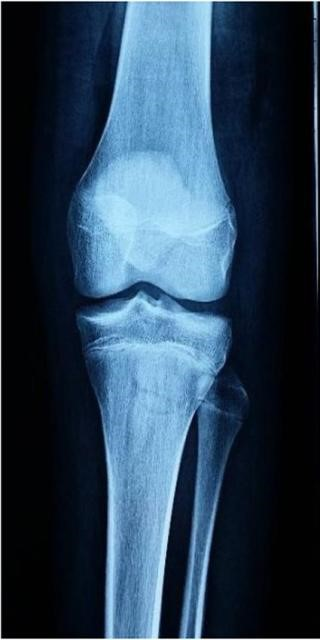

In [35]:
test_image

In [36]:
from transformers import pipeline

classifier = pipeline("image-classification", model="results/vit_bone_fractures/vit_bone_fractures_model")
classifier(test_image)

[{'label': 'Avulsion fracture', 'score': 0.3139253258705139},
 {'label': 'Comminuted fracture', 'score': 0.15840265154838562},
 {'label': 'Hairline Fracture', 'score': 0.10443779826164246},
 {'label': 'Fracture Dislocation', 'score': 0.07797788828611374},
 {'label': 'Spiral Fracture', 'score': 0.07387810945510864}]

In [37]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("vit_bone_fractures")
inputs = image_processor(test_image, return_tensors="pt")

In [38]:
with torch.no_grad():
    logits = model(**inputs).logits
int(dataset['train'][index]['label'])
# assert int(logits.argmax()) == int(dataset['train'][index]['label'])

0

In [39]:
int(logits.argmax().numpy()) 

0

In [ ]:
model.get_output_embeddings

# Test accuracy

In [27]:
test_set = dataset['test']
correct = 0
total = len(test_set)

for i in range(len(test_set)):
    image = test_set[i]['image']
    label = test_set[i]['label']
    inputs = image_processor(image, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits 
    if int(logits.argmax()) == label:
        correct += 1
print(correct/total, ' Accuracy')

0.2571428571428571  Accuracy


In [53]:
len(dataset['test'])

140

In [79]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("vit_bone_fractures")
with torch.no_grad():
    logits = model(inputs['pixel_values']).logits
logits

tensor([[-0.5400,  0.5351,  0.3146,  0.3190, -0.1910, -0.4357, -0.0950, -0.1917,
         -0.2280, -0.0555]])

In [13]:
import os

# Set your directory path
directory = r"C:/Users/jonpg/OneDrive/Documents/School/CS 770/image_classification_covid/Bone Break Classification/Oblique fracture/Train/"
count = 1
# Iterate through all files in the directory
for filename in os.listdir(directory):
    old_path = os.path.join(directory, filename)
    
    # Ensure it's a file
    if os.path.isfile(old_path):
        # Create a new filename by replacing spaces and special characters
        new_filename = 'image' + str(count) + '.jpg' # filename.replace(" ", "_").replace("-", "_").replace(",", "").replace("'", "")
        
        # # Shorten the name if too long
        # if len(new_filename) > 50:
        #     new_filename = new_filename[-50:]  # Truncate to 200 chars
        
        new_path = os.path.join(directory, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} -> {new_filename}")
        count += 1

print("Renaming complete.")


Renamed: image1 -> image1.jpg
Renamed: image10 -> image2.jpg
Renamed: image11 -> image3.jpg
Renamed: image12 -> image4.jpg
Renamed: image13 -> image5.jpg
Renamed: image14 -> image6.jpg
Renamed: image15 -> image7.jpg
Renamed: image16 -> image8.jpg
Renamed: image17 -> image9.jpg
Renamed: image18 -> image10.jpg
Renamed: image19 -> image11.jpg
Renamed: image2 -> image12.jpg
Renamed: image20 -> image13.jpg
Renamed: image21 -> image14.jpg
Renamed: image22 -> image15.jpg
Renamed: image23 -> image16.jpg
Renamed: image24 -> image17.jpg
Renamed: image25 -> image18.jpg
Renamed: image26 -> image19.jpg
Renamed: image27 -> image20.jpg
Renamed: image28 -> image21.jpg
Renamed: image29 -> image22.jpg
Renamed: image3 -> image23.jpg
Renamed: image30 -> image24.jpg
Renamed: image31 -> image25.jpg
Renamed: image32 -> image26.jpg
Renamed: image33 -> image27.jpg
Renamed: image34 -> image28.jpg
Renamed: image35 -> image29.jpg
Renamed: image36 -> image30.jpg
Renamed: image37 -> image31.jpg
Renamed: image38 -> 

# Shap

In [40]:
import numpy as np
import shap

In [42]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='Bone Break Classification')

In [53]:
index = 400
test_image = dataset['train'][index]['image']
dataset['train'][index]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x323>,
 'label': 3}

In [54]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("results/vit_bone_fractures/vit_bone_fractures_model")
inputs = image_processor(test_image, return_tensors="pt")
x_test = inputs['pixel_values'].numpy()
x_trans = x_test.transpose(0,2,3,1)
x_trans.shape

(1, 224, 224, 3)

In [55]:
labels

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

In [56]:

class_names = labels

In [57]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("results/vit_bone_fractures/vit_bone_fractures_model")

In [58]:
# python function to get model output; replace this function with your own model function.
import tensorflow as tf
def f(inputs):
    # print(inputs.shape)
    inputs = inputs.transpose(0,3,1,2)
    inputs = torch.Tensor(inputs)
    with torch.no_grad():
        logits = model(inputs).logits
    # print(logits)
    return logits.numpy()

In [59]:
f(x_trans)

array([[-0.26530442, -0.34102908, -0.02121754,  0.7531014 ,  0.07479377,
        -0.656129  , -0.10371169, -0.60101473, -0.46084577, -0.518564  ]],
      dtype=float32)

In [67]:



# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("blur(128,128)", x_trans[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

shap_values400 = explainer(x_trans, max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [07:20, 440.80s/it]              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].


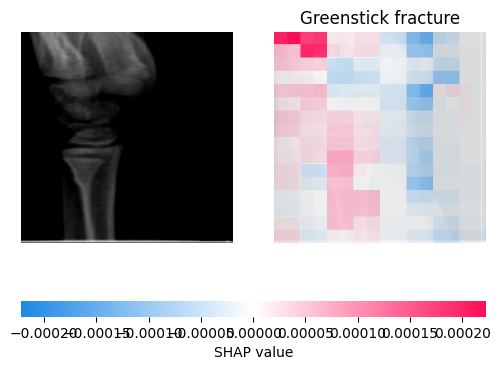

In [68]:
# output with shap values
shap.image_plot(shap_values400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].


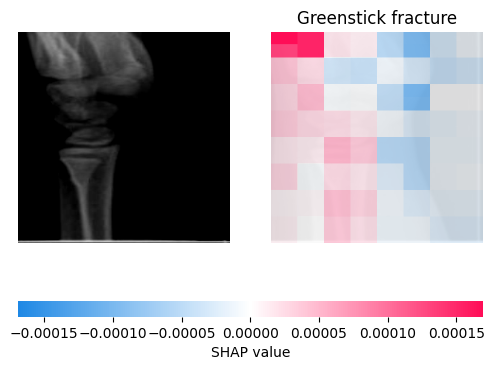

In [ ]:
# output with shap values
shap.image_plot(shap_values400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


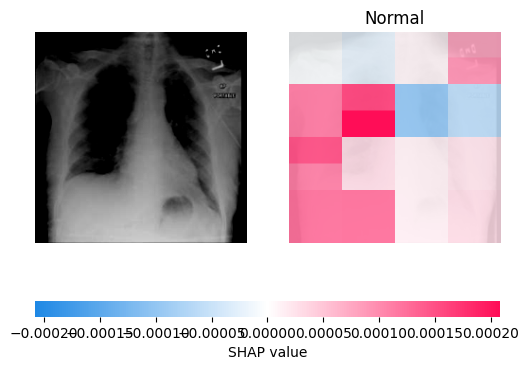

In [ ]:
# output with shap values
shap.image_plot(shap_values12500)

In [ ]:
combined = shap_values12345 + shap_values12500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


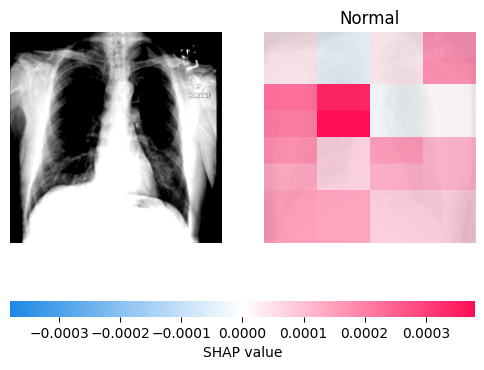

In [ ]:
shap.image_plot(combined)